## Loading Datasets

Datasets can be downloaded here:
* [Dog Dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location /data/dog_images. 

* [Human Dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in this project's home directory, at the location /data/lfw.  

After downloading, the datasets have been loaded into numpy arrays.

In [1]:
import numpy as np
from glob import glob

human_files = np.array(glob("./data/lfw/*/*"))
dog_files = np.array(glob("./data/dog_images/*/*/*"))
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 5749 total human images.
There are 8351 total dog images.


## Detecting Humans

Using OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html), I'm detecting human faces in images.  

Below is a simple demonstration on how to use this detector to find human faces in a sample image.

Number of faces detected: 1


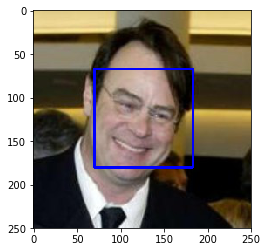

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
img = cv2.imread(human_files[0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray)
print('Number of faces detected:', len(faces))
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

## Human Face Detector
This function returns true/false if a human face is detected given a path of an image file. 

In [3]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

## Assessing the human face detector
I'm calling `face_detector()` on the first 100 images of the human face and dog dataset to test it out.

In [4]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

human_percentage = 0
dog_percentage = 0
for i in range(len(human_files_short)):
    if face_detector(human_files_short[i]):
        human_percentage += 1 
    if face_detector(dog_files_short[i]):
        dog_percentage += 1 
print('Percentage of human faces detected on human images: ', human_percentage,
      '%\nPercentage of human faces detected on dog images', dog_percentage, '%')

Percentage of human faces detected on human images:  98 %
Percentage of human faces detected on dog images 17 %


## Detecting dogs
I'm using a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images. Namely, the VGG16 model, that has been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks. ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [4]:
import torch
import torchvision.models as models

VGG16 = models.vgg16(pretrained=True)
use_cuda = torch.cuda.is_available()
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 102497483.60it/s]


## Predicting using VGG16
This function takes in an image path and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.

In [5]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to predicted ImageNet
    class for image at specified path
    '''

    transform = transforms.Compose([transforms.Resize(224),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    image = Image.open(img_path).convert('RGB')
    image = transform(image)[:3,:,:].unsqueeze(0)
    if use_cuda:
        image = image.cuda()
    predict = VGG16(image)
    return predict.data.cpu().argmax()

## Dog Detector
This function uses the `VGG16_predict` to identify if a dog is present in the image. The index checked between 151 and 268 as these indexes represent dog breeds in the ImageNet dataset.

In [6]:
def dog_detector(img_path):
    index = VGG16_predict(img_path)
    return index >= 151 and index <= 268

## Assessing the dog detector
I'm calling `dog_detector()` on the first 100 images of the human face and dog dataset to test it out.

In [8]:
human_percentage = 0
dog_percentage = 0

for i in range(len(human_files_short)):
    human_percentage += int(dog_detector(human_files_short[i]))
for i in range(len(dog_files_short)):
    dog_percentage += int(dog_detector(dog_files_short[i]))

print('Percentage of dog faces detected on human images: ', human_percentage, '%\nPercentage of dog faces detected on dog images', dog_percentage, '%')

Percentage of dog faces detected on human images:  1 %
Percentage of dog faces detected on dog images 100 %


## Loading data to classify dog breeds
Using `ImageFolder()`, I'm able to load the images as tensors and also apply data augmentations to increase the number of training example and avoid overfitting.

Finally, I use `DataLoader()` to create batches of the shuffled tensors.

In [7]:
import os
from torchvision import datasets

data_dir = '/data/dog_images/'
train_dir = data_dir + 'train/'
valid_dir = data_dir + 'valid/'
test_dir = data_dir + 'test/'

transform = {
    'train': transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
    'test': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
}

train_set = datasets.ImageFolder(train_dir, transform=transform['train'])
valid_set = datasets.ImageFolder(valid_dir, transform=transform['train'])
test_set = datasets.ImageFolder(test_dir, transform=transform['test'])

train_data = torch.utils.data.DataLoader(train_set, batch_size=20, shuffle=True)
valid_data = torch.utils.data.DataLoader(valid_set, batch_size=20, shuffle=False)
test_data = torch.utils.data.DataLoader(test_set, batch_size=20, shuffle=False)

## CNN Architecture
Using `torch.nn`, I build a CNN architecture as follows:

First convutltional layer: 224x224x3 -> 224x224x16 <br>
Max pooling layer: 224x224x16 -> 112x112x16 <br>
Second convultional layer: 112x112x16 -> 112x112x32 <br>
Max pooling layer: 112x112x32 -> 56x56x32 <br>
Third convultional layer: 56x56x32 -> 56x56x64 <br>
Max pooling layer: 56x56x64 -> 28x28x64 <br>
I used a standard kernel size of 3 and I didn't want any loss in pixels so I went with a padding of 1. My max pooling layer downsampled the x,y dimension by half by using padding and stride of 2. <br>
Next, I flattened the resulting image to supply it to my fully connected layers. <br>
I used 2 fully connected layers to help me provide the class probabilities. I used dropout in both the layers to avoid overfitting. I also used a relu activation function in the first layer. I didn't use any activatin function in the second layer as I'm using cross entropy loss. 

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 133)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(self.dropout(x))
        return x

model_scratch = Net()
if use_cuda:
    model_scratch.cuda()

## Setting loss and optimizer
As this is a classification problem, I'm using Cross Entropy Loss and sticking with Stochastic Gradient Descent as my optimizer.

In [11]:
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

## Training and Validating the model
Using the training and validation data I have created along with the CNN architechture, I train and valdiate the model and save the model parameters.

In [19]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer_scratch.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        if valid_loss_min > valid_loss:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
            print('Saving model.')
            
    return model

loaders_scratch = {
    'train': train_data,
    'valid': valid_data,
    'test': test_data
}
model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.856456 	Validation Loss: 4.780464
Saving model.
Epoch: 2 	Training Loss: 4.711460 	Validation Loss: 4.647180
Saving model.
Epoch: 3 	Training Loss: 4.577959 	Validation Loss: 4.594058
Saving model.
Epoch: 4 	Training Loss: 4.460397 	Validation Loss: 4.432564
Saving model.
Epoch: 5 	Training Loss: 4.307676 	Validation Loss: 4.319126
Saving model.
Epoch: 6 	Training Loss: 4.184033 	Validation Loss: 4.259361
Saving model.
Epoch: 7 	Training Loss: 4.078992 	Validation Loss: 4.212890
Saving model.
Epoch: 8 	Training Loss: 3.995225 	Validation Loss: 4.163255
Saving model.
Epoch: 9 	Training Loss: 3.896964 	Validation Loss: 4.201874
Epoch: 10 	Training Loss: 3.786278 	Validation Loss: 4.090811
Saving model.
Epoch: 11 	Training Loss: 3.686944 	Validation Loss: 4.071714
Saving model.
Epoch: 12 	Training Loss: 3.566757 	Validation Loss: 4.184616
Epoch: 13 	Training Loss: 3.444950 	Validation Loss: 4.194410
Epoch: 14 	Training Loss: 3.314154 	Validation Loss: 4.177258
E

## Testing the Model
Now, to check the model's performance on unseen data, I'm running the trained model which I have saved against the testing data.

In [29]:
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
def test(loaders, model, criterion, use_cuda):

    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.038152


Test Accuracy: 10% (89/836)


## Bad Results
The accuracy I got was 10% which is poor. But this can be due to the fact that my CNN model is pretty simple and it needs to be more complex to capture intricate features. Dog breed classification is a hard task even for humans! So, only a deep CNN with state-of-art architecture with huge compute will be to classify this probelem.

## New Approach: Transfer Learning
There are trained deep state-of-the-art CNNs available for us to use. Using these pre-trained models will help my case and this can be done by transfer learning.

I load the pre-trained VGG16 model and freeze its features as I want to use them for my problem. Then, I replace the final linear layer with a linear layer that suits the number of dog classes we need.

In [8]:
import torchvision.models as models
import torch.nn as nn

loaders_transfer = loaders_scratch
model_transfer = models.vgg16(pretrained=True)
for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, 133, bias=True)
model_transfer.classifier[6] = last_layer
if use_cuda:
    model_transfer = model_transfer.cuda()
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.01)

## Training and Validation

In [27]:
model_transfer = train(10, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.310824 	Validation Loss: 1.295281
Saving model.
Epoch: 2 	Training Loss: 1.331956 	Validation Loss: 0.744810
Saving model.
Epoch: 3 	Training Loss: 0.903799 	Validation Loss: 0.616346
Saving model.
Epoch: 4 	Training Loss: 0.716288 	Validation Loss: 0.529885
Saving model.
Epoch: 5 	Training Loss: 0.601759 	Validation Loss: 0.512923
Saving model.
Epoch: 6 	Training Loss: 0.534861 	Validation Loss: 0.473488
Saving model.
Epoch: 7 	Training Loss: 0.447411 	Validation Loss: 0.494860
Epoch: 8 	Training Loss: 0.399854 	Validation Loss: 0.458000
Saving model.
Epoch: 9 	Training Loss: 0.356993 	Validation Loss: 0.430481
Saving model.
Epoch: 10 	Training Loss: 0.312127 	Validation Loss: 0.456506


## Testing

In [16]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.485669


Test Accuracy: 86% (722/836)


Better accuracy is achieved through transfer learning from VGG16. Other pre-trained models can also be used for this puropse.

## Predicting dog breed given an image
This function uses the trained model as a predictor to return a dog breed given an image.

In [9]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
class_names = [item[4:].replace("_", " ") for item in train_set.classes]

def predict_breed_transfer(img_path):
    image = Image.open(img_path).convert('RGB')
    image_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    image = image_transform(image)[:3,:,:].unsqueeze(0)
    if use_cuda:
        image = image.cuda()
    output = model_transfer(image)
    return class_names[output.data.cpu().argmax()]

This function uses the `dog_detector()` `face_dectector()` created above to identify if dogs or humans are present in an image and accordingly calls `predict_breed_transfer()` to predict a dog breed.

In [ ]:
def run_app(img_path):
    predicted_breed = predict_breed_transfer(img_path)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    
    if dog_detector(img_path):
        print("It's a dog. Predicted breed:", predicted_breed)
    elif face_detector(img_path):
        print("It's a human. Closest dog breed resemblance:", predicted_breed)
    else:
        print('Error: Neither human nor dog.')

## MY RESULTS!

In [ ]:
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

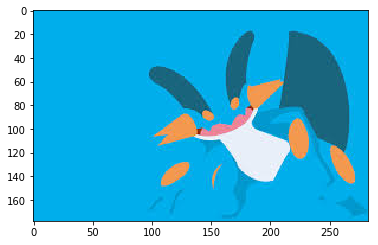

Error: Neither human nor dog.


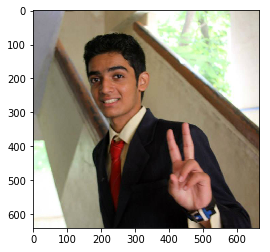

It's a human. Closest dog breed resemblance: Dachshund


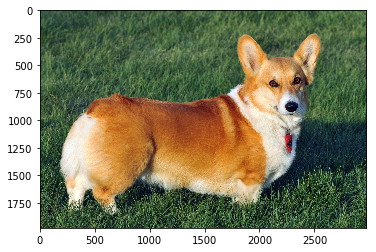

It's a dog. Predicted breed: Pembroke welsh corgi


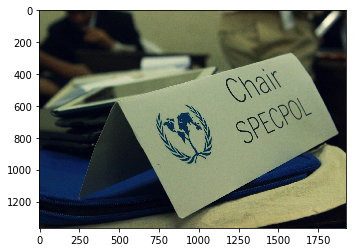

Error: Neither human nor dog.


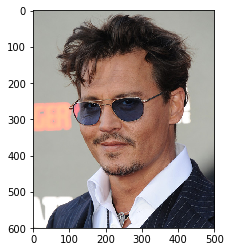

It's a human. Closest dog breed resemblance: Irish terrier


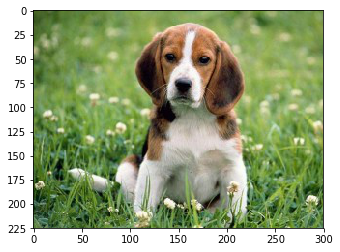

It's a dog. Predicted breed: Beagle


In [25]:
for file in os.listdir('./my_images/'):
    if 'jpg' in file:
        run_app(os.path.join('./my_images/',file))